In [1]:
import glob
import json
from smart_open import open
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import utils
from torch import optim

from senseis.torch_module.model import RegressorV1
from senseis.torch_module.dataset import XYDataset
from senseis.torch_module.reporter import SReporter
from senseis.torch_module.loss import CorrelationLoss

from sklearn.metrics import r2_score
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_built()
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')

In [4]:
data_dir = '../data/'

In [5]:
config_filename = data_dir + 'one_volatility_prediction_v1.json'

In [6]:
files = glob.glob(data_dir + 'etl_s2_v2*.parquet')
files

['../data/etl_s2_v2_1681390080_1681543680.parquet',
 '../data/etl_s2_v2_1680419520_1680590400.parquet',
 '../data/etl_s2_v2_1680112320_1680265920.parquet',
 '../data/etl_s2_v2_1680897600_1681051200.parquet',
 '../data/etl_s2_v2_1681697280_1681850880.parquet',
 '../data/etl_s2_v2_1679805120_1679958720.parquet',
 '../data/etl_s2_v2_1681850880_1682004480.parquet',
 '../data/etl_s2_v2_1680744000_1680897600.parquet',
 '../data/etl_s2_v2_1679958720_1680112320.parquet',
 '../data/etl_s2_v2_1680590400_1680744000.parquet',
 '../data/etl_s2_v2_1679178240_1679331840.parquet',
 '../data/etl_s2_v2_1680265920_1680419520.parquet',
 '../data/etl_s2_v2_1679485440_1679651520.parquet',
 '../data/etl_s2_v2_1681082880_1681236480.parquet',
 '../data/etl_s2_v2_1681543680_1681697280.parquet',
 '../data/etl_s2_v2_1679651520_1679805120.parquet',
 '../data/etl_s2_v2_1681236480_1681390080.parquet',
 '../data/etl_s2_v2_1679331840_1679485440.parquet']

In [7]:
ticker = 'ETH-USD'

In [8]:
with open(config_filename, 'r') as fd:
    training_config = json.load(fd)

In [9]:
ticker_columns = [ticker + ':' + colname for colname in training_config['ticker_column_names']] + training_config['global_column_names']

In [10]:
data = pd.DataFrame(columns=ticker_columns)
for file in files:
    df = pd.read_parquet(file, columns=ticker_columns)
    data = pd.concat([data, df])

In [11]:
data.sort_index(inplace=True)

In [12]:
data.shape

(2750371, 708)

In [13]:
target_column_names = [ticker + ':' + target['target_name'] for target in training_config['targets']]

In [14]:
for target in training_config['targets']:
    data[ticker + ':' + target['target_name']] = data[ticker + ':' + target['source_name']]
    data[ticker + ':' + target['target_name']] = data[ticker + ':' + target['target_name']].shift(-1 * target['shift'])

In [15]:
maxshift = max([target['shift'] for target in training_config['targets']])

In [16]:
data = data.drop([data.index[k] for k in range(-1, -1 * (maxshift + 1), -1)])

In [17]:
data.shape

(2749411, 715)

In [18]:
data.isna().sum().sum()

12966173

In [19]:
data.fillna(method='ffill', inplace=True)

In [20]:
data.replace([np.inf, -np.inf], method='ffill', inplace=True)

In [21]:
data.isna().sum().sum()

0

In [22]:
for col in data.columns:
    max_val = np.nanmax(data[col][data[col] != np.inf])
    min_val = np.nanmin(data[col][data[col] != -np.inf])
    data[col].replace([np.inf, -np.inf], [max_val, min_val], inplace=True)

In [23]:
data.isna().sum().sum()

0

In [24]:
data.fillna(0., inplace=True)

In [25]:
input_columns = [col for col in data.columns if col not in target_column_names]

In [26]:
X = np.float32(data[input_columns].to_numpy())

In [27]:
Y = np.float32(data[target_column_names].to_numpy())

In [28]:
def ts_train_test_split(X, Y, pct):
    n = X.shape[0]
    train_size = int(n * pct)
    X_train = X[:train_size]
    Y_train = Y[:train_size]
    X_test = X[train_size:]
    Y_test = Y[train_size:]
    return (X_train, Y_train, X_test, Y_test)

In [29]:
X_train, Y_train, X_test, Y_test = ts_train_test_split(X, Y, training_config['train_pct'])

In [30]:
# normalize X otherwise neural network becomes degenerative

In [31]:
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)

In [32]:
X_train_std[X_train_std == 0.] = 1.

In [33]:
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

In [34]:
Y_train_mean = Y_train.mean(axis=0)
Y_train_std = Y_train.std(axis=0)

In [35]:
Y_train_norm = (Y_train - Y_train_mean) / Y_train_std
Y_test_norm = (Y_test - Y_train_mean) / Y_train_std

In [36]:
def regression_train(model, device, loader, optimizer, loss, epoch, reporter):
    model.train()
    total_loss = 0.
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model(data)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        total_loss += l.item()
    loss = total_loss / len(loader.dataset)
    print("Train Epoch: {} Loss: {}".format(epoch, loss))
    reporter.report(typ='train', loss=loss)

In [37]:
def regression_validate(model, device, loader, loss, train_epoch, reporter):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for (data, target) in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += loss(output, target).item()
    total_loss /= len(loader.dataset)
    reporter.report(typ='eval', loss=total_loss)

In [38]:
def regression_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epoch, patience, patience_decay, reporter):
    validation_loss = 1.
    patience_count = patience
    patience = int(patience * patience_decay)
    reset_patience = False
    for epoch in range(total_epoch):
        regression_train(model, device, train_loader, optimizer, loss, epoch, reporter)
        regression_validate(model, device, eval_loader, loss, epoch, reporter)
        new_validation_loss = reporter.eval_loss(-1)
        scheduler.step(new_validation_loss)
        if new_validation_loss < validation_loss:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count = patience
            if reset_patience:
                patience = int(patience * patience_decay)
                reset_patience = False
        else:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count -= 1
            reset_patience = True
            if patience_count <= 0:
                print("Improvement stopped at epoch {}, validation loss {}".format(epoch, new_validation_loss))
                break

In [39]:
# training

In [40]:
trainset, evalset = XYDataset(X_train_norm, Y_train_norm), XYDataset(X_test_norm, Y_test_norm)

In [41]:
train_loader = utils.data.DataLoader(trainset, **training_config['loader_args'])
eval_loader = utils.data.DataLoader(evalset, **training_config['score_args'])

In [42]:
model = RegressorV1(len(input_columns), len(target_column_names), training_config['nn_hidden_size'])
model = model.to(device)

In [43]:
learning_rate = training_config['learning_rate']
total_epochs = training_config['total_epochs']
patience = training_config['patience']
patience_decay = training_config['patience_decay']
optimizer = optim.Adam(model.parameters(recurse=True), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience / 4, threshold=training_config['threshold'])
loss = nn.MSELoss()
#loss = CorrelationLoss()
reporter = SReporter()

In [44]:
regression_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epochs, patience, patience_decay, reporter)

Train Epoch: 0 Loss: 0.0018865926558894505
Validation Loss: 0.001993569203459466
Train Epoch: 1 Loss: 0.0016448572455181395
Validation Loss: 0.0019888441707644365
Train Epoch: 2 Loss: 0.0016125833320615336
Validation Loss: 0.0019884258416207647
Train Epoch: 3 Loss: 0.0015910046667840041
Validation Loss: 0.002005178075966296
Train Epoch: 4 Loss: 0.0015748908603832013
Validation Loss: 0.0020228316154809987
Train Epoch: 5 Loss: 0.0015615018154702533
Validation Loss: 0.002031823225292951
Train Epoch: 6 Loss: 0.0015543052825899343
Validation Loss: 0.0020347036489093365
Train Epoch: 7 Loss: 0.001553121867608327
Validation Loss: 0.002036114662913144
Train Epoch: 8 Loss: 0.0015519854377711755
Validation Loss: 0.002038802392109747
Improvement stopped at epoch 8, validation loss 0.002038802392109747


In [45]:
X_valid = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Y_predict_norm = model(X_valid).to(cpu).detach().numpy()
Y_predict = (Y_predict_norm * Y_train_std) + Y_train_mean

In [46]:
r, p = pearsonr(Y_test[:,0], Y_predict[:,0])
r

0.6561294334443712

In [47]:
r, p = pearsonr(Y_test[:,1], Y_predict[:,1])
r

0.7042416922660523

In [48]:
r, p = pearsonr(Y_test[:,3], Y_predict[:,3])
r

0.6916146500184822

In [49]:
r, p = pearsonr(Y_test[:,6], Y_predict[:,6])
r

0.5816493219168545

In [50]:
r2_score(Y_test, Y_predict)

0.4297991698570052

In [51]:
# plotting it out

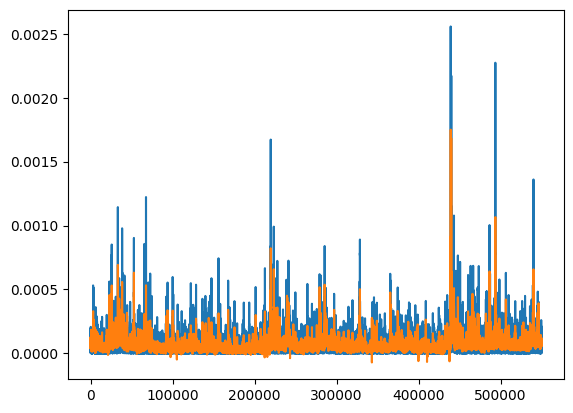

In [52]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,0])
ax.plot(Y_predict[:,0])

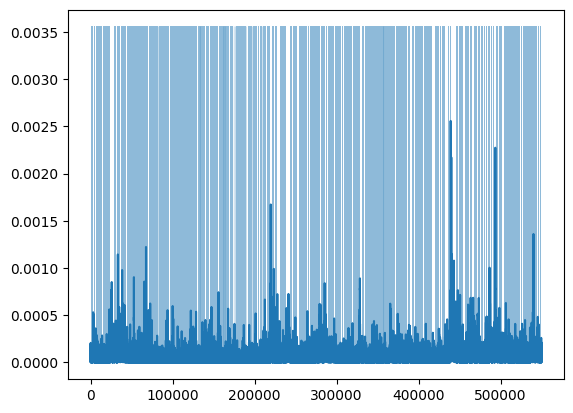

In [53]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,0])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,0]), max(Y_test[:,0]) + 0.001, where=np.abs(Y_test[:,0] - Y_predict[:,0]) < 0.00005, alpha=0.5)

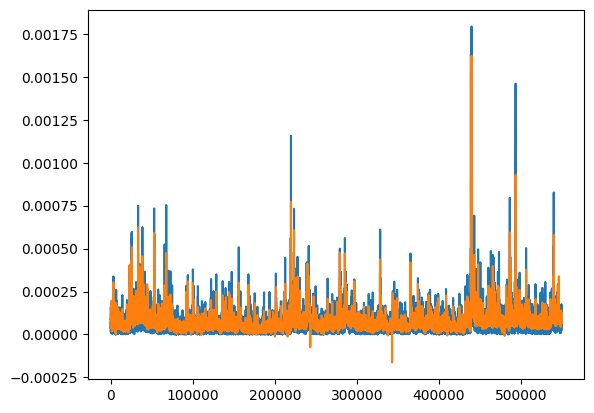

In [54]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,1])
ax.plot(Y_predict[:,1])

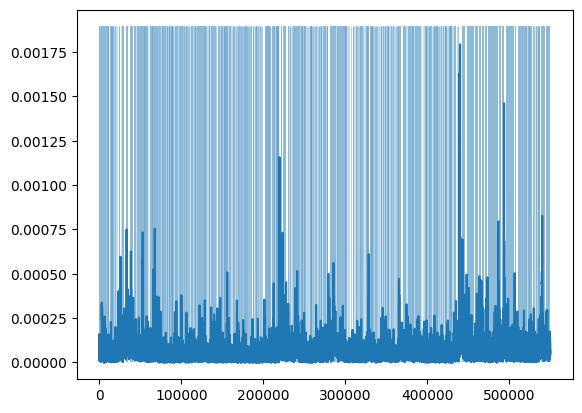

In [55]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,1])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,1]), max(Y_test[:,1]) + 0.0001, where=np.abs(Y_test[:,1] - Y_predict[:,1]) < 0.00005, alpha=0.5)

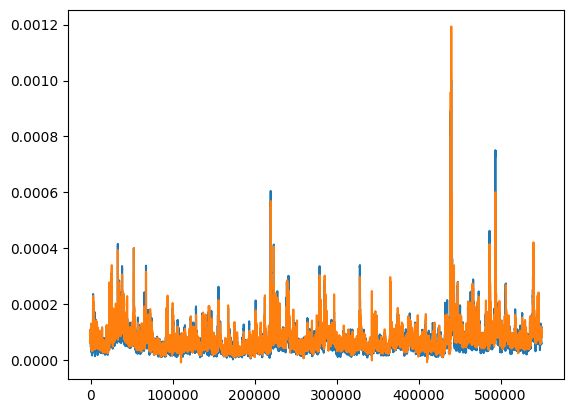

In [56]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,3])
ax.plot(Y_predict[:,3])

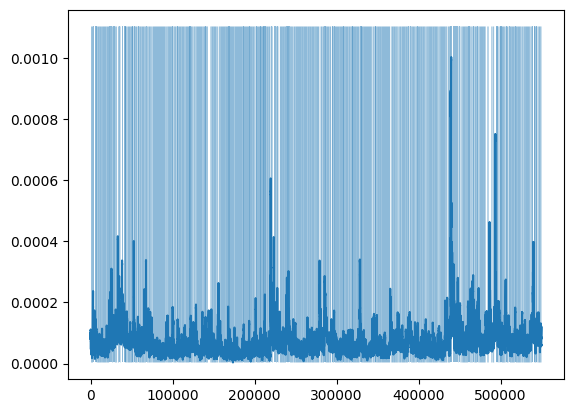

In [57]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,3])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,3]), max(Y_test[:,3]) + 0.0001, where=np.abs(Y_test[:,3] - Y_predict[:,3]) < 0.00005, alpha=0.5)

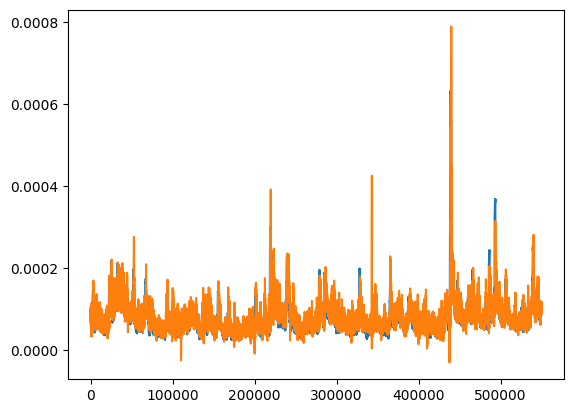

In [58]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,6])
ax.plot(Y_predict[:,6])

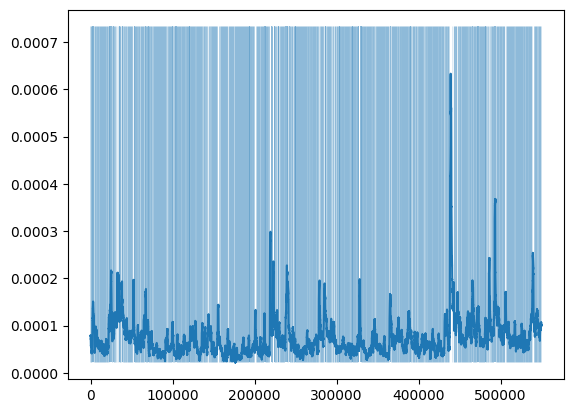

In [59]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,6])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,6]), max(Y_test[:,6]) + 0.0001, where=np.abs(Y_test[:,6] - Y_predict[:,6]) < 0.00005, alpha=0.5)